In [3]:
import pandas as pd # data manipulation
import numpy as np # numerical operations
import json # json handling
import time # time operations
import os # os operations

from sklearn.model_selection import train_test_split, StratifiedKFold # data splitting and cross-validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report # evaluation metrics

from sklearn.feature_extraction.text import TfidfVectorizer # text feature extraction
from sklearn.linear_model import LogisticRegression # classification model

import seaborn as sns # data visualization for confusion matrices
import matplotlib.pyplot as plt # plotting

# OpenAI API for LLM integration and error handling
from openai import OpenAI, BadRequestError, APIError, RateLimitError, APITimeoutError 
# Error code descriptions can be found at: https://platform.openai.com/docs/guides/error-codes/python-sdk-errors

# Classifying Factuality of AI-Generated Texts in Educational Content

**The 4th Annual Data4Good Competition**
(Oct 2025 - Jan 2026)

**Team:** The White Hatters

**University/Department:** The University of Washington, Foster School of Business

**Program:** Masters of Science in Business Analytics (MSBA)


### Team Members:
- Anushka Mathur, MSBA'26 ([LinkedIn](https://www.linkedin.com/in/anushka-mktg-analytics/))
- Archit Gupta, MSBA'26 ([LinkedIn](https://www.linkedin.com/in/thearchitgupta/))
- Natthapat Sakulborrirug, MSBA'26 ([LinkedIn](https://www.linkedin.com/in/natthapat-sakulborrirug/))
- Alex Weng, MSBA'26 ([LinkedIn](https://www.linkedin.com/in/alexweng97/))

*Analysis "Domains" guided using IAF (Informs Analytics Framework) developed by INFORMS (Institute for Operations Research and Management Sciences). Learn more at [INFORMS Website](https://www.informs.org/Professional-Development/Professional-Development-Classes/INFORMS-Analytics-Framework)*

---



# List of Contents
1. Business Problem Framing
2. Analytics Problem Framing
3. Data
4. Methodology Framing
5. Analytics/Model Development 
6. Deployment
7. Analytics Solution Lifecycle Management
8. Appendix (Source code for Models in Experimentation Log)




---



# Executive Summary

This project, developed by team "The White Hatters" from the University of Washington for the 4th Annual Data4Good Competition, addresses the growing concern of "hallucinations" and factual errors in AI-generated educational materials. The following points summarize the scope, methodology, and key findings of the analytics solution:

Business Problem Framing: The rapid adoption of Large Language Models (LLMs) in education is hindered by their tendency to produce confidently incorrect or fabricated content, which erodes learner trust and creates reputational risks for platform providers.

Analytics Problem Framing: The project frames factuality detection as a multiclass classification problem, aiming to categorize AI responses into three mutually exclusive classes: factual, contradictory, or irrelevant.

Data Characteristics: The study utilized a labeled dataset of 21,021 training records containing questions, context, and AI-generated answers; exploratory analysis revealed a significant class imbalance, with approximately 82.9% of responses being factual, and includes a deep dive into text features

Methodology Framing: 2 families of methods identified (Classical ML and LLM as Judge) for exploration. Defined success is measured using the Macro F1-Score to ensure balanced performance across all classes, and lay groundwork for cross-validation and model evaluation (confusion matrices and classification reports)

Model Development: Experimentation of log of model provided. Deep dive into 2 most successful models, including LLM-as-Judge, which the team submitted the test set against, and an ensemble model developed through extensive feature engineering. 

Deployment Considerations: Potential integrations such as into EdTech platforms identified, as well as challenges that may arise from biases and API expenses.  

Solution Lifecycle Management: Defined monitoring changing characteristics of questions and contexts an essential process to detect drift, as well as additional features not in current project scope that can enhance the solution further

---



# Domain I: Business Problem Framing

## Context

Artificial Intelligence–powered tools, particularly Large Language Models (LLMs), are increasingly embedded in educational platforms to support learning through instant explanations, tutoring, and content generation. While these tools significantly improve accessibility and efficiency, they introduce a critical risk: LLMs can confidently generate factually incorrect, contradictory, or irrelevant responses, commonly referred to as hallucinations.

In an educational setting, such errors have outsized consequences. Students may unknowingly absorb incorrect information, educators may lose trust in AI-assisted tools, and platform providers face reputational, adoption, and potential legal risks. Despite these challenges, the benefits of AI-assisted learning are too substantial for institutions to abandon. As a result, the problem is not whether to use LLMs, but how to ensure their outputs are trustworthy and responsibly monitored.


**From Case Challenge:**

*Artificial Intelligence (AI) is rapidly transforming education by providing students with instant access to information and adaptive learning tools. Still, it also introduces significant risks, such as the spread of misinformation and fabricated content. Research indicates that large language models (LLMs) often confidently generate factually incorrect or “hallucinated” responses, which can mislead learners and erode trust in digital learning platforms.*


## Problem Statement

The explosive growth of LLMs has democratized access to educational content through educational learning platforms, AI tutors, and conversational interfaces. Despite the benefits, LLMs are still prone to providing incorrect answers and "hallucinations". This negatively impacts the learning of students, and undermines reliability of these platforms for learning purposes. While the access and efficiency benefits of LLMs are too substantial for learners and institutions to abandon, if left unaddressed, these issues risk driving negative reviews, reduced adoption, and even legal challenges against providers.  

This gives rise to the question:

**How can educational stakeholders reliably identify and flag factually incorrect, contradictory, or irrelevant AI-generated responses at scale, while preserving the efficiency benefits of AI-powered learning tools?**

A reliable detection mechanism enables:
- Improved learner trust and educational quality
- Responsible AI deployment aligned with institutional values
- Scalable quality control without manual review
- A foundation for continuous model improvement through feedback loops


## Project Scope

Scope for solving business problem as follows due to timeline and data access constraints.

**In-Scope:**

1. Determining whether text content generated is factual or not, given labelled data for training.

**Out of Scope:**
1. Implementation of model on content involving generated multimodal content (Audio, Video, Images) is not included in this project.
2. Non-English texts will not be evauluated  
3. Real-time deployment and front-end design
4. Correction or regeneration of correct content (detection only)
5. Feedback mechanisms to re-label wrong predictions.

## Business Case for Solution
- Education Technology
- Catch any false answers produced by LLMs
- Any LLM use case really, as if text is generated, we want to check if it is factual
- Makes product more reliable overall 

## Stakeholder Analysis
- Platforms leveraging LLM and want to add another layer of checking factuality. 
- E.g Education Technology Specifically

## Implementation Considerations
- Pre-existing bias in training data ("Factual" is dependent on what is accepted as truth in training data), this can be important for certain events like history where different people have different accounts of what happeed. Less of an issue in "harder" disciplines like the sciences



---



# Domain II: Analytics Problem Framing

## Analytics Problem Statement 

Since factuality is a categorical variable, detecting it in LLM generated texts is a classification problem. As will be seen later in the Data domain, the data given to train the model contains labels on whether a generated text is 1) Factual, 2) Contradictory, or 3) Irrelevant. As there are 3 prediction classes, this is specifically multiclass classification problem, and falls under the predictive analytics level of analysis.  

The analytic problem being approached is therefore:

**To Develop a multiclass classification model that is able to identify factuality of LLM generated answers, given a question, its reference context, and an AI generated answer as inputs, and a label on whether the answer is factual/contradictory/irrelevant.**

## Inputs 

The primary inputs consist of textual data:
- Question: The original educational query
- Context: Reference material used to answer the question
- Answer: AI-generated response to be evaluated

## Outputs

Categorical label with three mutually exclusive classes:
- factual
- contradiction
- irrelevant

## Assumptions
1. Labeled data accurately reflects factual correctness based on authoritative context
2. The three classes sufficiently capture the most relevant forms of AI-generated error in educational content
3. Textual patterns and stylistic cues provide signal for detecting factual reliability, even without deep semantic reasoning
4. The distribution of errors in historical data is representative of near-term deployment scenarios

## Baseline and Current State
There is no existing automated solution. The baseline state is equivalent to:
- Manual review or
- Naïve prediction of all responses as factual

Empirical baseline modeling confirms that while such approaches yield high overall accuracy due to class imbalance, they completely fail to detect contradictory and irrelevant content. This establishes the necessity of alternative evaluation metrics and modeling strategies.

## Measures of Success
Primary success metrics focus on balanced performance across all classes, rather than raw accuracy:
- Macro F1-Score (primary), this is the most holistic metric to capture balanced performance across all classes
- Per-class precision and recall for error analysis 
- Confusion matrix analysis to visually understand error trade-offs

Accuracy is tracked but not used as the primary optimization objective due to its susceptibility to imbalance bias.

## Risks and Mitigation

1. Over-optimizing for accuracy at the expense of minority error detection
2. Model bias toward predicting “factual” responses

Mitigation Strategies:

1. Use of stratified cross-validation and macro-averaged metrics
2. Sensitivity analysis to determine impact of minority-class errors, and weight tradeoffs of being sensitive to certain classes
3. Iterative model benchmarking and validation


## Stakeholder Alignment
The analytics framing explicitly aligns:
1. Educational institutions (learning quality and trust)
2. Platform providers (scalability and reputational risk)
3. Students (accuracy and reliability of learning content)

By focusing on error detection rather than content generation, the solution complements existing AI systems, with potential to make them more robust.









---



# Domain III: Data
## Requirements
Factuality detection requires a labelled dataset of actual factualiies of AI-generated educational content. Mimicing the use of AI tools, each record neds to include a question (given to the chatbot), its context (any context given to chatbot previosly), a corresponding answer, and a ground-truth label indivating whether the answer is factual, contradictory, or irrelevant. This data needs to have sufficient volume for model training and validation, and should be representative of class proporations. 

From this, various text processing approaches can be taken to analyze semantics in modelling pipeline.

## Sources
Dataset is provided to all participants in the form of 2 JSON files, a training set, and a testing set with labels held out from contestants:

- Training dataset (21,021 records) containing question, context, answer, and type
- Test dataset (2,000 records) containing the same fields plus a unique ID

Both datasets were loaded into pandas DataFrames. All text fields were stored as string objects, while labels were categorical. The datasets were well-structured, tabular after ingestion, and required no schema restructuring prior to analysis pipeline.

- These data sources will be explored in following EDA sections, and can be accessed via the data folder of the project repository.

### Assessment of Source:
**Volume:** High, 21K rows provides sufficient data for training a model, and a held out test set allows for reliable testing

**Velocity:** N/A, data source is static and fixed. In deployment, this is high as LLM produces magnitudes of content each day.

**Veracity:** High, as the schema is simple (1 table, 4 columns) and missing values arise from actual usage (user did not provide context). These are represented as blank cells, so there are no null values. *Considerations regarding labelling Bias need to be kept in mind, as there is no information regarding the data collection process.*

**Variety:** Low, data is in 1 file format (JSON) and data rows are all in text format.

**Value:** High, as data is real data from LLMs that has been labelled with their corresponding factuality.
## Model Output
- Any outputs produced by developed models with also be stored in the project repository under the predictions folder.

## Management Plan

Data managemetn plan focuses on reproducibility, traceability, and consistency through following rules:

1. Raw JSON files preserved without modification, and are stored in /Data directory
2. Intermediate datasets (feature-engineered versions) are generated programmatically and not manually edited. 
3. Feature scaling, label encoding, and train–validation splits are performed using fixed random seeds to ensure reproducibility. 
4. Final outputs (predictions on the test set) to be evaluated are validated and saved in the required JSON format pipeline.

## EDA (Exploratory Data Analysis) - Training Data

**Data Cleaning:** No stemming, lemmatization, and removal of stop words, as in LLM generated text, meaning needs to be preserved. These cleaning may be done in specific models developed in project for some model-specific feature engineering tasks.

First 5 rows of the training data:


,answer,type,context,question
0,"In 1512, Parliament passed a significant act t...",factual,During the Hundred Years' War a French attack ...,In what year did Parliament pass a notable law...
1,The Spanish and French were the ones who estab...,factual,"""By May 1539, Conquistador Hernando de Soto sk...",Who established early settlements in Florida
2,"Traditionally, monsoons in Punjab are expected...",factual,The onset of the southwest monsoon is anticipa...,When do monsoons traditionally happen in Punjab?
3,The media made the requests for Kondo to use o...,factual,Media requests at the trade show prompted Kond...,Who made the requests for Kondo to use orchest...
4,According to historians Robert Friedel and Pau...,factual,In addressing the question of who invented the...,How many inventors came up with electric lamps...


Sample from each class in training data:


/var/folders/f9/h1fzr8_920x1wh3dtpzy4cmh0000gn/T/ipykernel_67626/2768547184.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(train_df.groupby('type').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True))


,answer,type,context,question
0,the Greek tradition of isolationism and econom...,contradiction,The roots of Greek success in the Ottoman Empi...,What did the Greeks offer to the Ottoman Empir...
1,Two separate successive elections are required...,factual,Articles 77–79 of the Norwegian Constitution s...,How many elections are required to assend a bi...
2,Apple Inc. has its European headquarters locat...,irrelevant,"West's middle-class background, flamboyant fas...",What overabundance of themes did Kanye critici...


Null Value Check in Training Data:


answer      0
type        0
context     0
question    0
dtype: int64

Shape of the training data:
21021 rows and 4 columns


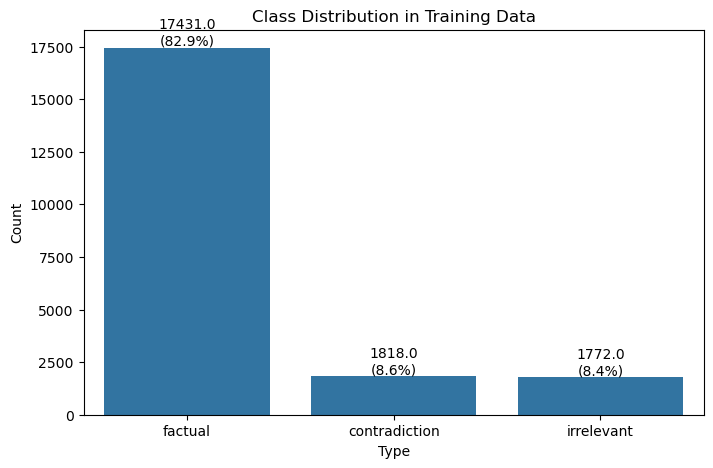

Describe each column in training data:


,answer,type,context,question
count,21021,21021,21021,21021
unique,20670,3,12441,21018
top,1945,factual,,What was the name of Alonso de Salazar's ship?
freq,6,17431,1869,2


Looking at some repeat questions in training data:


,answer,type,context,question
2621,Queen Victoria and Prince Albert had a total o...,factual,"Victoria married her first cousin, Prince Albe...",How many children did Queen Victoria and Princ...
13099,The shells of conch are a pearly-pink color.,irrelevant,"Victoria married her first cousin, Prince Albe...",How many children did Queen Victoria and Princ...
6921,Alonso de Salazar's ship was called the Santa ...,factual,Spanish explorer Alonso de Salazar was the fir...,What was the name of Alonso de Salazar's ship?
7357,Alonso de Salazar's ship was named Santa Maria...,factual,Spanish explorer Alonso de Salazar was the fir...,What was the name of Alonso de Salazar's ship?
3398,"Maurice Hilleman, a scientist at Merck Sharp &...",factual,"During the years 1940-1955, the rate of declin...",Who identified the SV40 virus?


Looking at some repeat answers in training data:


,answer,type,context,question
8403,1789,contradiction,Evidence exists that native peoples traveled t...,When did France sell Oklahoma's land to the US?
14813,1789,contradiction,The economic structure of the Empire was defin...,When did Christopher Columbus sail to the Baha...
17742,1895,contradiction,The first degrees from the college were awarde...,In what year did the initial degrees get hande...
13559,1895,contradiction,The last great period of Roman mosaic art was ...,What year was the medallion above the gate of ...
10072,1895,contradiction,,In what year was Edmond Rostand's L'Aiglon wri...


Looking at some repeat (non-blank) context in training data:


,answer,type,context,question
8187,The starting point of the Olympic torch route ...,factual,"\n Australia: The event was held in Canberra, ...",What was the location of the beginning of the ...
5607,The Aboriginal elder who received the Olympic ...,factual,"\n Australia: The event was held in Canberra, ...",What is the name of the Aboriginal elder who r...
15238,"During a press conference, it was Australian a...",factual,"\n Australia: The event was held in Canberra, ...",Who publicly argued at a press conference?
9885,The city that hosted the 2012 Summer Olympics ...,factual,\n Great Britain: The torch relay leg held in ...,What city held the Olympics in 2012?
996,The torch relay for the 2008 Olympics began at...,factual,\n Great Britain: The torch relay leg held in ...,Where did the torch relay begin in London for ...


Blank Contexts in the Training Data:
Rows with blank contexts: 1869 (8.89%)
Class distribution in blank contexts:


type
factual          1573
irrelevant        150
contradiction     146
Name: count, dtype: int64

Class distribution in blank contexts (percentage):


type
factual          84.162654
irrelevant        8.025682
contradiction     7.811664
Name: proportion, dtype: float64

Rows where both question and context are repeated in training data:


,answer,type,context,question
2621,Queen Victoria and Prince Albert had a total o...,factual,"Victoria married her first cousin, Prince Albe...",How many children did Queen Victoria and Princ...
13099,The shells of conch are a pearly-pink color.,irrelevant,"Victoria married her first cousin, Prince Albe...",How many children did Queen Victoria and Princ...
6921,Alonso de Salazar's ship was called the Santa ...,factual,Spanish explorer Alonso de Salazar was the fir...,What was the name of Alonso de Salazar's ship?
7357,Alonso de Salazar's ship was named Santa Maria...,factual,Spanish explorer Alonso de Salazar was the fir...,What was the name of Alonso de Salazar's ship?
3398,"Maurice Hilleman, a scientist at Merck Sharp &...",factual,"During the years 1940-1955, the rate of declin...",Who identified the SV40 virus?
10370,"Maurice Hilleman, a scientist at Merck Sharp &...",factual,"During the years 1940-1955, the rate of declin...",Who identified the SV40 virus?


In [10]:
# Load the train.json file into a DataFrame
data_path = "data/train.json"
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
train_df = pd.DataFrame(data)

# Show the first 50 rows
print("First 5 rows of the training data:")
display(train_df.head(5))

# Sample from each class
print("Sample from each class in training data:")
display(train_df.groupby('type').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True))

print("Null Value Check in Training Data:")
display(train_df.isnull().sum())

# Shape: 21021 rows of data with 4 columns
print("Shape of the training data:")
print(train_df.shape[0], "rows and", train_df.shape[1], "columns")

# Visualize class distribution with data labels
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='type', order=train_df['type'].value_counts().index)
plt.title('Class Distribution in Training Data')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks()
# Add data labels on top of bars. Also show percentage of total for each class.
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}\n({height / len(train_df) * 100:.1f}%)',
                       (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom')
plt.show()

# Describe each column to see basic statistics, missing values, unique values, repeat values
print("Describe each column in training data:")
display(train_df.describe())

# Looking at duplicate questions, answers, and contexts
print("Looking at some repeat questions in training data:")
duplicate_questions = train_df[train_df.duplicated(subset=['question'], keep=False)]
display(duplicate_questions.sort_values(by=['question']).head(5))

print("Looking at some repeat answers in training data:")
duplicate_answers = train_df[train_df.duplicated(subset=['answer'], keep=False)]
display(duplicate_answers.sort_values(by=['answer']).head(5))

print("Looking at some repeat (non-blank) context in training data:")
duplicate_contexts = train_df[train_df.duplicated(subset=['context'], keep=False)]
duplicate_contexts = duplicate_contexts[duplicate_contexts['context'].notnull() & (duplicate_contexts['context'] != '')]
display(duplicate_contexts.sort_values(by=['context']).head(5))

print("Blank Contexts in the Training Data:")
blank_contexts = train_df[train_df['context'].isnull() | (train_df['context'] == '')]
print(f"Rows with blank contexts: {len(blank_contexts)} ({len(blank_contexts) / len(train_df) * 100:.2f}%)")
print("Class distribution in blank contexts:")
display(blank_contexts['type'].value_counts())
print("Class distribution in blank contexts (percentage):")
display(blank_contexts['type'].value_counts(normalize=True) * 100)

# rows where both question and context are repeated
print("Rows where both question and context are repeated in training data:")
duplicate_qc = train_df[train_df.duplicated(subset=['question', 'context'], keep=False)]
display(duplicate_qc.sort_values(by=['question', 'context']).head(50))

### Key Observations
- Same Question and Context can yield differences answers due to non-deterministic nature of LLM models

### Text Characteristics Analysis

Text Length Statistics:
       question_length  context_length  answer_length  question_words  \
count     21021.000000    21021.000000   21021.000000    21021.000000   
mean         59.381143      686.349127      89.662718       10.072261   
std          21.349175      360.602114      44.490616        3.586801   
min          12.000000        0.000000       1.000000        2.000000   
25%          44.000000      526.000000      62.000000        8.000000   
50%          56.000000      665.000000      83.000000       10.000000   
75%          71.000000      867.000000     110.000000       12.000000   
max         201.000000     3706.000000     642.000000       34.000000   

       context_words  answer_words  
count   21021.000000  21021.000000  
mean      109.056848     14.325769  
std        57.754782      6.894050  
min         0.000000      1.000000  
25%        83.000000     10.000000  
50%       106.000000     13.000000  
75%       138.000000     18.000000  
max       653.000000  

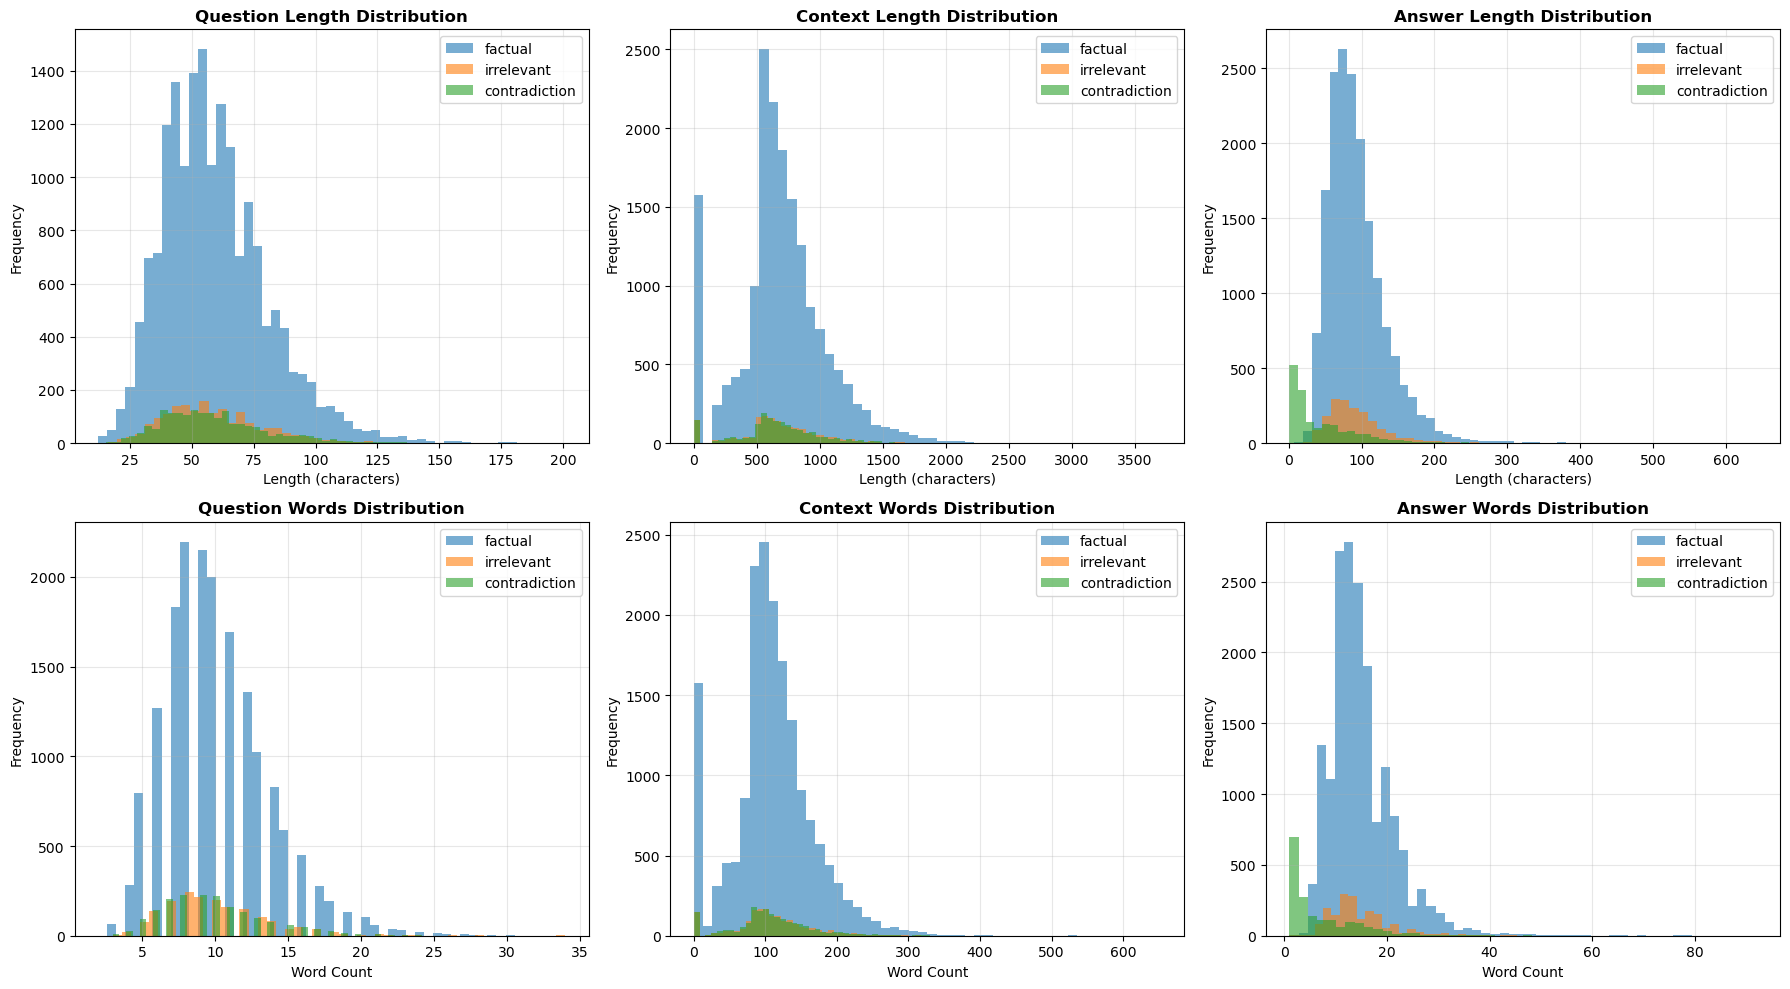

In [6]:
# Text length analysis
train_df['question_length'] = train_df['question'].str.len()
train_df['context_length'] = train_df['context'].str.len()
train_df['answer_length'] = train_df['answer'].str.len()

# Word count analysis
train_df['question_words'] = train_df['question'].str.split().str.len()
train_df['context_words'] = train_df['context'].str.split().str.len()
train_df['answer_words'] = train_df['answer'].str.split().str.len()

# Display statistics
print("Text Length Statistics:")
print(train_df[['question_length', 'context_length', 'answer_length',
                'question_words', 'context_words', 'answer_words']].describe())

# Visualize text length distributions by type
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Question length by type
for i, col in enumerate(['question_length', 'context_length', 'answer_length']):
    for type_val in train_df['type'].unique():
        data = train_df[train_df['type'] == type_val][col]
        axes[0, i].hist(data, alpha=0.6, label=type_val, bins=50)
    axes[0, i].set_title(f'{col.replace("_", " ").title()} Distribution', fontweight='bold')
    axes[0, i].set_xlabel('Length (characters)')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

# Word count by type
for i, col in enumerate(['question_words', 'context_words', 'answer_words']):
    for type_val in train_df['type'].unique():
        data = train_df[train_df['type'] == type_val][col]
        axes[1, i].hist(data, alpha=0.6, label=type_val, bins=50)
    axes[1, i].set_title(f'{col.replace("_", " ").title()} Distribution', fontweight='bold')
    axes[1, i].set_xlabel('Word Count')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

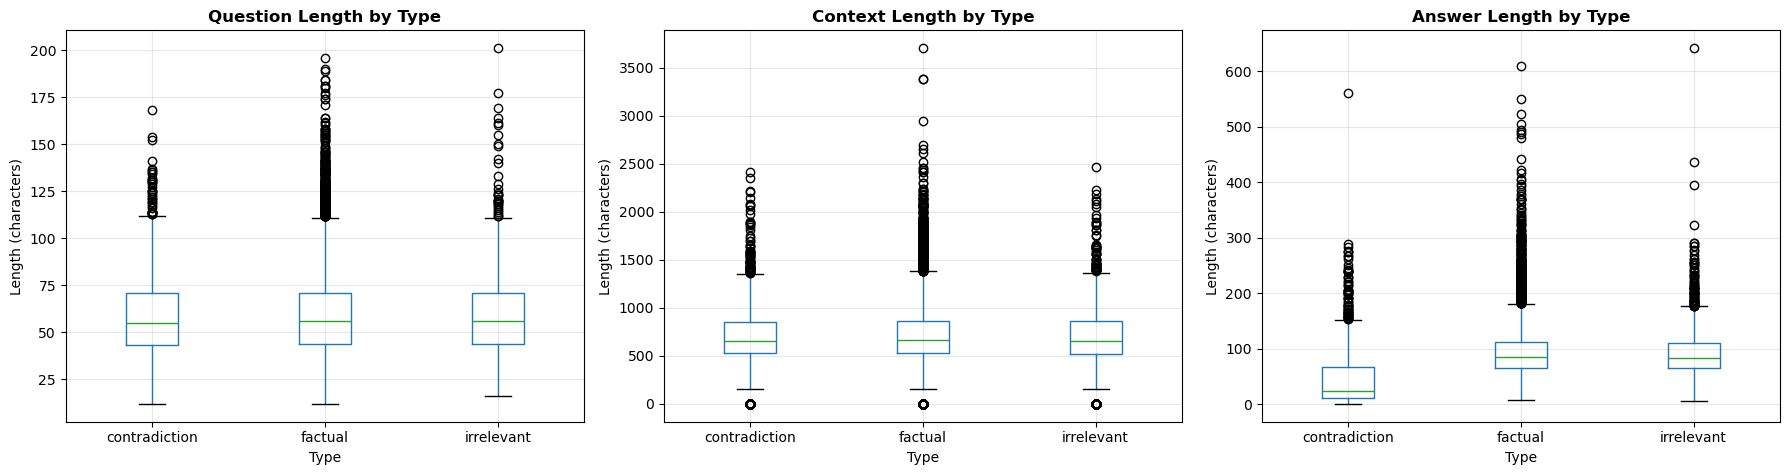

In [8]:
# Box plots for text lengths by type
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(['question_length', 'context_length', 'answer_length']):
    train_df.boxplot(column=col, by='type', ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").title()} by Type', fontweight='bold')
    axes[i].set_xlabel('Type')
    axes[i].set_ylabel('Length (characters)')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('')
plt.tight_layout()
plt.show()

## EDA (Exploratory Data Analysis) - Test Data

In [13]:
# Load the train.json file
data_path = "data/test.json"
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
test_df = pd.DataFrame(data)

# Show the first 5 rows
print("First 5 rows of the test data:")
display(test_df.head(5))
print("Shape of the testing data:")
print(test_df.shape[0], "rows and", test_df.shape[1], "columns")

# repeat answers in test data
duplicate_test_answers = test_df[test_df.duplicated(subset=['answer'], keep=False)]
duplicate_test_answers = duplicate_test_answers[duplicate_test_answers['answer'].notnull() & (duplicate_test_answers['answer'] != '')]
print()
print("Looking at some repeat answers in test data:")
display(duplicate_test_answers.sort_values(by=['answer']))

# number of blank contexts in test data
blank_test_contexts = test_df[test_df['context'].isnull() | (test_df['context'] == '')]
print(f"Rows with blank contexts in test data: {len(blank_test_contexts)} ({len(blank_test_contexts) / len(test_df) * 100:.2f}%)")


First 5 rows of the test data:


,ID,answer,type,context,question
0,1,"In the mid-19th century, the Bronx was referre...",,The Bronx street grid is irregular. Like the n...,What was the Bronx called in the mid-19th cent...
1,2,"Beyoncé's father, Mathew Knowles, began managi...",,,When did Beyoncé begin to manage the girl group?
2,3,Dionysus was similar to the Roman god Bacchus.,,"While the new plebeian nobility made social, p...",To what Roman god was Dionysus similar?
3,4,The most crucial defense in preventing the spr...,,"Techniques like hand washing, wearing gowns, a...",What is the most important defense against the...
4,5,The third largest long term acute care provide...,,The Baylor College of Medicine has annually be...,What is the third largest acute care center in...


Shape of the testing data:
2000 rows and 5 columns

Looking at some repeat answers in test data:


,ID,answer,type,context,question
516,517,Africans and mixed-race children were consider...,,The story takes place during three years (1933...,Atticus Finch's children make friends with who...
1120,1121,Africans and mixed-race children were consider...,,"In South Africa, the period of colonization re...",What class were Africans and Mixed Race childr...
438,439,"In 2012, 6.3% of New York City's population wa...",,"More recently, articles in various financial p...",The $900 million Forbes said Castro took may o...
594,595,"In 2012, 6.3% of New York City's population wa...",,Two types of charging port exist: the charging...,What are the D+ and D- shortened with?
990,991,Tuvalu was first discovered by a European in t...,,North Carolina was inhabited for thousands of ...,What was the largest city in the Piedmont befo...
1648,1649,Tuvalu was first discovered by a European in t...,,"In 1568, Spanish navigator Álvaro de Mendaña w...",In what year was Tuvalu discovered by a European?


Rows with blank contexts in test data: 185 (9.25%)


## **Outcomes**

1.   Identified Data Sources: Structured JSON training and test datasets with labeled factuality outcomes
2.   Data Management Plan: Reproducible pipeline with controlled transformations, versioned outputs, and validation checks
3. EDA & Data Cleaning: Comprehensive exploratory analysis with no missing data and meaningful feature extraction
4. Post-Cleaning Data Quality Assessment: High completeness, clear feature–label relationships, and strong readiness for modeling (supported by summary statistics and visualizations)



---



# Domain IV: Methodology Framing

## 2 Main Groups of Methods:
1. Supervised Machine Learning Methods, including but not limited to:
- Logistic Regression
- SVC
- Random Forest
- XG Boost

Requires extensive feature engineering to convert text data into interpretable vectors, and analyze whether patterns can be identified that correlate to the correct label. Feature engineering is a open-book and there are numerous features, as well as combinations of features that can be derived. Thus, it can become a time consuming method with large exploration potential. 

2. LLM as a Judge
- Using prompting and LLMs, which are able to understand natural language, to perform classification. Since it does not necessarily use all the data labels, it is not strictly a supervised training task, although those examples can be given to the model.
- Involves setting up API connections if using propietary models, or downloading models if using Open-Weight models.
- API calls come at a cost depending on the model.
- Additionally, models may be a black box and their classifications may be less interpretable.
- Models have a knowledge cutoff which may limit ability to interpret and classify more recent prompts. 
- Also has large exploration potential, as developer can also explore prompts and fine tuning methods

## Tech Stack
- Python and python libraries within Jupyter Notebook environment, allows for quick exploration of data and experimentation with different methods.

## Approach
Development runs in parallel, exploring both families of solution and tracking experimentation within each. Highest scoring test set to be submitted at competition deadline.

## Validation Method
- Stratified K-Fold Cross validation, defined in code block below, will be used to validate Supervised Training models. This prevents overfitting and removes biases. A stratified method is used to address class imbalances present in the model. 
- Functions to evaluating predictions against actuals are also defined in code block below, which will be used to print out a visual confusion matrix as well as classification report.
- For LLM as Judge models, prompts will be validated against the training data directly. 

## Metrics to Evaluate
We evaluate models using **Accuracy** and **Macro F1**. Accuracy reflects overall system correctness, while Macro F1 ensures balanced performance across all semantic classes in the presence of class imbalance. Precision and Recall are reported for error analysis. ROC AUC is not applicable since the task requires discrete multi-class decisions rather than probability ranking.”

## K-Fold, and Evaluation Functions

In [ ]:
classes = sorted(train_df['type'].unique())  # alphabetical order of classes. Used for consistent confusion matrix display and labeling.

# Use Stratified K-Fold to Address Class-Imbalances. 
# This kf will be reused throughout the notebook. No need to redefine, this will ensure all models use the same splits.
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to print confusion matrix
def print_confusion_matrix(true_labels, pred_labels, labels):
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    cm_df = pd.DataFrame(
        cm,
        index=[f"True: {c}" for c in labels],
        columns=[f"Pred: {c}" for c in labels]
    )
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Function to evaluate model. Calls print_confusion_matrix, and also generates classification report
def evaluate_model(true_labels, pred_labels, labels):
    print_confusion_matrix(true_labels, pred_labels, labels)
    print(classification_report(true_labels, pred_labels, zero_division=0))






---



# Domain V: Analytics/Model Development
<a name="Model-Development"></a>

## Overview

The modelling strategy involves iterative cycles, with increasing complexity to experiment with different features, feature sets, and models what would achieve highest accuracy and macro F1 scores. The main area of interest is increasing performance gains in minority classes (contradition and irrelevant).

Feature engineering is model specific, as rationales to use certrain features and feature sets may differ among models.

## Experimentation Log
| Model                                                         | Feature Engineering                                                                                                              | Accuracy | Precision Macro | Recall Macro | F1 Macro |
| ------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------- | -------- | --------------- | ------------ | -------- |
| Majority Classifier                                           | N/A                                                                                                                              | 0.8292   | 0.2764          | 0.3333       | 0.3022   |
| Logistic Regression Baseline                                  | TF-IDF Vectorization of concatenated Question, Context, Answer                                                                   | 0.8297   | 0.6099          | 0.3352       | 0.3059   |
| Logistic Regression (Class Weight = Balanced)                 | TF-IDF Vectorization of concatenated Question, Context, Answer                                                                   | 0.6301   | 0.365           | 0.3837       | 0.3638   |
| Logistic Regression (Class Weight = Balanced) + ngrams(1,3)   | TF-IDF Vectorization of concatenated Question, Context, Answer                                                                   | 0.7016   | 0.3631          | 0.3634       | 0.3621   |
| LLM as Judge - Zero Shot (Deepseek API)                       | Concatenated Q, A, C into single input                                                                                           | 0.95     | 0.85            | 0.9          | 0.87     |
| LLM as Judge - 2 Stage + Few Shot (OpenAI API)                | Concatenated Q, A, C into single input                                                                                           | 0.98     | 0.93            | 0.96         | 0.94     |
| Ensemble Model (Random Forest, XG Boost, Logistic Regression) | Character lengths, Word counts, Sentence counts, Word overlap ratios, Semantic similarity scores, scaling + encoding of features | 0.965    | 0.97            | 0.87         | 0.91     |


## Additional Planned Experiments
These experiments were noted for trial but unable to be complete in within time frame. Future project enhancements can include testing them:

1. Mofidying concatenation methods, such as adding separators when combining Questions, Answers, and Context for Vectorization
2. Vectorizing columns separately
3. Support Vector Classifier (SVC) family of models
4. Untested Feature Engineering
- Keyword overlaps
- Punctuation count
- Jaccard Similarity
- Entity Match and Mismatch Counts
5. Using Factuality Scoring Models to achieve scores that can be used as features. 2 notable examples:
- ALIGN Score
- BART Score

## Section Structure
Code and results of all experiments can be found in appendix. The main body will include the two highest performing approaches which include:
1) LLM as a Judge (Used for final submission)
2) Ensemble Model (Using 3 ML models and extensive feature engineering), similarly achieved high scores on validation set (20% of training data) without need for external API calls.

## Modeling: LLM as a Judge (Submitted Approach)

*Note: Score of 5889 on Test Set*

LLM as a Judge is an evaluation method, using LLMs to evaluate outputs. It requires the precise design of prompts and criteria to guide the decision boundaries of evaluation. In this case, the evaluation is a classification task. 

Prompting methods will be evaluated, increasing complexity in iterations to investigate improvements in performance.

### Deepseek API: Zero Shot POC

- The Deepseek API was identified as a suitable testing LLM due to its lower costs. 
- Setup involves installing OpenAI SDK, Creating account of Deepseeks API platform and loading credits (5$ is enough to start with)
- The following code goes over the setup of defining system prompts for the evaluation as well as defining a function to compile the Question, Answer, and Contexts into a User Prompt

In [ ]:
# Deep Seek AI Chat Completion Example
# If have not already, Please install OpenAI SDK first: `pip3 install openai`

# Using OpenAI SDK (imported at top of notebook) to interact with Deep Seek API
client = OpenAI(api_key='INSERT HERE', base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a sarcastic person"},
        {"role": "user", "content": "Write an essay on history of USA?"}
    ],
    temperature=0,
    max_tokens=15,
    stream=False
)

print(response.choices[0].message.content)

Of course. Here is an essay on the history of the United States,


In [ ]:
# Zero Shot Prompt Generation
LABELS = classes

JUDGE_SYSTEM = """You are a strict evaluator for a QA task.

Labels:
- factual: The answer is supported by the context and answers the question.
- contradiction: The answer is non factual.
- irrelevant: The answer is unrelated to the question.

Return ONLY which label it is.
"""

def make_judge_prompt(question, context, answer):
    return f"""QUESTION:
{question}

CONTEXT:
{context}

ANSWER:
{answer}
"""

print("System Prompt Used for Judge:")
print(JUDGE_SYSTEM)
# Separator
print("-----------------")
print("Sample Zero-Shot Prompt:")
print(make_judge_prompt(train_df.loc[0, 'question'], train_df.loc[0, 'context'], train_df.loc[0, 'answer']))

System Prompt Used for Judge:
You are a strict evaluator for a QA task.

Labels:
- factual: The answer is supported by the context and answers the question.
- contradiction: The answer is non factual.
- irrelevant: The answer is unrelated to the question.

Return ONLY which label it is.

-----------------
Sample Zero-Shot Prompt:
QUESTION:
How many different types of iPod are currently available?

CONTEXT:
The iPod is a line of portable media players and multi-purpose pocket computers designed and marketed by Apple Inc. The first line was released on October 23, 2001, about 8½ months after iTunes (Macintosh version) was released. The most recent iPod redesigns were announced on July 15, 2015. There are three current versions of the iPod: the ultra-compact iPod Shuffle, the compact iPod Nano and the touchscreen iPod Touch.

ANSWER:
There are currently three different types of iPod available.



In [ ]:
def judge_row(question: str, context: str, answer: str) -> str:
    question = question or "" # If field is None or empty, replace with empty string
    context  = context or "" # If field is None or empty, replace with empty string
    answer   = answer or "" # If field is None or empty, replace with empty string

    resp = client.chat.completions.create(
        model="deepseek-chat",
        temperature=0, # deterministic
        messages=[
            {"role": "system", "content": JUDGE_SYSTEM},
            {"role": "user", "content": make_judge_prompt(question, context, answer)},
        ],
        max_tokens=10, # only 1 word expected, so limit tokens
        stream=False # no streaming
    )

    content = resp.choices[0].message.content.strip() # get the response content, strip whitespace
    # Ensures valid label is returned
    try:
        obj = json.loads(content)
        label = obj.get("label", "").strip()
    except Exception:
        label = content.strip()

    if label not in LABELS: # Guardrail: ensure label is valid
        raise ValueError(f"Invalid label returned: {content}")

    return label

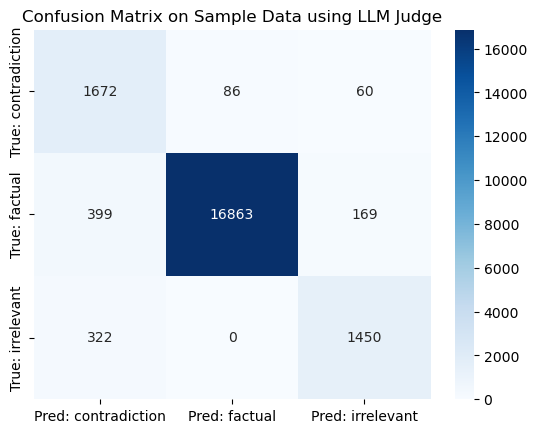

               precision    recall  f1-score   support

contradiction       0.70      0.92      0.79      1818
      factual       0.99      0.97      0.98     17431
   irrelevant       0.86      0.82      0.84      1772

     accuracy                           0.95     21021
    macro avg       0.85      0.90      0.87     21021
 weighted avg       0.96      0.95      0.95     21021



In [ ]:
# Run on training data to see performance
for idx, row in train_df.iterrows():
    pred_label = judge_row(row['question'], row['context'], row['answer'])
    train_df.at[idx, 'type_pred'] = pred_label
evaluate_model(train_df['type'], train_df['type_pred'], LABELS)

#### Key Takeaways
- DeepSeek API runs into many errors during running. Their censorship prevents certrain topics such as history from being evaluated, and the model had to be rerun by defauling those values to "factual". This can cause issues in production, and informed the shift to OpenAI's GPT-5 family of models in further experiments.
- Clearest class of error is within irrelevant, where there is never a misclassification as factual, but a large number at contradiction.

### OpenAI API: Model Improvements and Prompt Tuning

#### Stage #1: 2 Step Reasoning 
The observed pattern regarding relevance is something that can be reproduced even in OpenAIs GPT-5 models, indicating that it is a common error mode among LLMs. It is unable to distinguish whether an answer is wrong and irrelevant. Since relevance seems to be indepdent of factuality, it does not matter if an answer is right/wrong if it is unrelated to the question, adding a reasoning step  to first determine relevance is a logical step. 

In [ ]:
# System Prompt Used
'''
You are a strict evaluator for a QA task.

Your job is to assign exactly ONE of the following labels:
- factual
- contradiction
- irrelevant

Follow this decision procedure exactly:

Step 1 — Relevance:
Decide whether the ANSWER attempts to answer the QUESTION (is it on-topic?).
You may use the CONTEXT only to understand the topic of the question.
If the answer is off-topic, a non-sequitur, or does not attempt to answer the question,
return: irrelevant
and stop.

Step 2 — Correctness (only if relevant):
Use the CONTEXT as the primary evidence.
- If the answer is supported by the context, return: factual
- If the answer is wrong, return: contradiction

If the context is missing or does not clearly address the answer:
- Only return contradiction if the answer is clearly false, internally inconsistent,
  or obviously wrong by general knowledge.
- Otherwise, default to: factual

Important rules:
- Do NOT return contradiction just because the context is long, different, or contains
  unrelated information.
- An answer that does not address the question is irrelevant, not contradiction.

Return ONLY the label.
'''

In [ ]:
# Create a smaller sample dataset for testing LLM prompts
'''
It is too slow to test on all 21021 training rows. We need to create a smaller sample of out labelled data to test.
We want to see if the LLM is good at classifying ALL classes, so will create a small sample with balanced classes.
We will take 150 random samples from each class, and copy so that it does not affect original indices.

'''
N_PER_CLASS = 150
SEED = 42
samples = []
for label, group in train_df.groupby("type"): # for each class label, and all rows in that class
    n_samples = min(len(group), N_PER_CLASS) # in case some classes have less than N_PER_CLASS
    
    # Randomly sample rows from this class
    sampled_group = group.sample(
        n=n_samples,
        random_state=SEED
    )
    
    samples.append(sampled_group) # append those sampled rows to samples list

train_df_sample = pd.concat(samples).sample(frac=1, random_state=SEED).reset_index(drop=True).copy()
print("Sample size:", len(train_df_sample))
print(train_df_sample["type"].value_counts())
train_df_sample["preds"] = ""  # empty column for predicted labels later

Sample size: 150
type
factual          50
contradiction    50
irrelevant       50
Name: count, dtype: int64


##### Result
- Tested on a smaller subset of the data with equal examples from each class (150 rows, so 450 total), the Irrelevance issue become completely addressed. 


- Contradiction: 131 predicted, 9 mis-classed as factual, 10 mis-classed as irrelevant
- Factual: 149 predicted, 1 mis-classed as contradiction
- Irrelevant: 150 predicted

Observations:
- Irrelevant became the most common misclassification among contradictions, likely due to the prompt change increasing sensitivty to borderline contradictions as irrelevance.
- In other words, answers that a wrong are being classed as unrelated.

#### Stage 2: Prompt Improvements

Addressing the issue identified in Stage #1, the following line was added to the prompt

In [ ]:
'''
If the answer is on-topic and makes an attempt (even if incorrect), it is NOT irrelevant.
Irrelevant is only for off-topic / non-sequitur / no attempt to answer.
'''

##### Result
- Tested on same sample of data as Stage #1
- Contradiction: 137 predicted, 9 mis-classed as factual, 4 mis-classed as irrelevant
- Factual: 147 predicted, 3 mis-classed as contradiction
- Irrelevant: 150 predicted

Observations:
- Near perfect performance, with errors that might be borderline cases. Addressing this ambiguity may come with trade ofs between classiying whether borderline cases between factual/contradiction are classified as the other. 

### Stage 3: Addition of Few-Shot Examples

To aid model performance, few shot examples can be added to the prompt to provide additional expectations on behavior. 

#### Result
- Tested on same sample of data as Stage #1
- Contradiction: 139 predicted, 9 mis-classed as factual, 2 mis-classed as irrelevant
- Factual: 148 predicted, 1 mis-classed as contradiction, 1 mis-classed as irrelevant
- Irrelevant: 150 predicted

Observations:
- Improvement in accurate predictions across all classes. This performance can be tested on the full training set for a thorough evaluation.


### Final Full Training Set Validation and use on Test Set


In [ ]:
for idx, row in train_df_sample.iterrows():
    pred_label = judge_row(row['question'], row['context'], row['answer'])
    train_df_sample.at[idx, 'preds'] = pred_label

![image](openai2.png)

In [ ]:
# Use on Test for Submission
for idx, row in test_df.iterrows():
    pred_label = judge_row(row['question'], row['context'], row['answer'])
    test_df.at[idx, 'type'] = pred_label
output_path = "data/test_predictions.json"
test_df.to_json(output_path, orient="records", lines=False)

## Modeling: Ensemble ML Model

*Note: Score of 4350 on Test Set*


### Feature Engineering

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

In [15]:
def extract_features(df):
    """
    Extract various features from question, context, and answer
    """
    features = df.copy()

    # Basic text features
    features['question_length'] = features['question'].str.len()
    features['context_length'] = features['context'].str.len()
    features['answer_length'] = features['answer'].str.len()

    features['question_words'] = features['question'].str.split().str.len()
    features['context_words'] = features['context'].str.split().str.len()
    features['answer_words'] = features['answer'].str.split().str.len()

    # Ratio features
    features['answer_to_question_ratio'] = features['answer_length'] / (features['question_length'] + 1)
    features['answer_to_context_ratio'] = features['answer_length'] / (features['context_length'] + 1)
    features['question_to_context_ratio'] = features['question_length'] / (features['context_length'] + 1)

    # Word overlap features
    def word_overlap(text1, text2):
        words1 = set(text1.lower().split())
        words2 = set(text2.lower().split())
        if len(words1) == 0 or len(words2) == 0:
            return 0
        return len(words1.intersection(words2)) / len(words1.union(words2))

    features['question_answer_overlap'] = features.apply(
        lambda x: word_overlap(x['question'], x['answer']), axis=1
    )
    features['context_answer_overlap'] = features.apply(
        lambda x: word_overlap(x['context'], x['answer']), axis=1
    )
    features['question_context_overlap'] = features.apply(
        lambda x: word_overlap(x['question'], x['context']), axis=1
    )

    # Question word features
    question_words = ['what', 'who', 'when', 'where', 'why', 'how', 'which', 'whom', 'whose']
    for qw in question_words:
        features[f'has_{qw}'] = features['question'].str.lower().str.contains(qw, regex=False).astype(int)

    # Answer starts with question word
    features['answer_starts_with_question_word'] = features.apply(
        lambda x: any(x['answer'].lower().startswith(qw) for qw in question_words), axis=1
    ).astype(int)

    # Number of sentences
    features['question_sentences'] = features['question'].str.count(r'[.!?]+')
    features['context_sentences'] = features['context'].str.count(r'[.!?]+')
    features['answer_sentences'] = features['answer'].str.count(r'[.!?]+')

    # Capitalization features
    features['answer_caps_ratio'] = features['answer'].str.findall(r'[A-Z]').str.len() / (features['answer_length'] + 1)
    features['question_caps_ratio'] = features['question'].str.findall(r'[A-Z]').str.len() / (features['question_length'] + 1)

    # Special characters
    features['answer_special_chars'] = features['answer'].str.findall(r'[^a-zA-Z0-9\s]').str.len()
    features['question_special_chars'] = features['question'].str.findall(r'[^a-zA-Z0-9\s]').str.len()

    # Numeric features
    features['answer_has_numbers'] = features['answer'].str.contains(r'\d', regex=True).astype(int)
    features['question_has_numbers'] = features['question'].str.contains(r'\d', regex=True).astype(int)
    features['context_has_numbers'] = features['context'].str.contains(r'\d', regex=True).astype(int)

    return features

# Apply feature engineering
print("Extracting features from training data...")
train_features = extract_features(train_df)
print("Extracting features from test data...")
test_features = extract_features(test_df)
print("Feature engineering complete!")


Extracting features from training data...
Extracting features from test data...
Feature engineering complete!


In [16]:
# Calculate semantic similarity using TF-IDF and cosine similarity
print("Calculating semantic similarities...")

# Combine question and context for better comparison
train_features['question_context_combined'] = train_features['question'] + ' ' + train_features['context']
test_features['question_context_combined'] = test_features['question'] + ' ' + test_features['context']

# TF-IDF vectorization for semantic similarity
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Fit on training data
train_qc_vectors = vectorizer.fit_transform(train_features['question_context_combined'])
train_answer_vectors = vectorizer.transform(train_features['answer'])

# Transform test data
test_qc_vectors = vectorizer.transform(test_features['question_context_combined'])
test_answer_vectors = vectorizer.transform(test_features['answer'])

# Calculate cosine similarity
train_features['semantic_similarity'] = [
    cosine_similarity(train_qc_vectors[i:i+1], train_answer_vectors[i:i+1])[0][0]
    for i in range(len(train_features))
]

test_features['semantic_similarity'] = [
    cosine_similarity(test_qc_vectors[i:i+1], test_answer_vectors[i:i+1])[0][0]
    for i in range(len(test_features))
]

print("Semantic similarity calculation complete!")

Calculating semantic similarities...
Semantic similarity calculation complete!


### Model Development

We'll try multiple approaches:
1. Traditional ML models (Random Forest, XGBoost, etc.)
2. Transformer-based models (BERT, RoBERTa, etc.)
3. Ensemble methods

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Prepare features for traditional ML
feature_columns = [col for col in train_features.columns
                   if col not in ['question', 'context', 'answer', 'type', 'question_context_combined', 'ID']]

X = train_features[feature_columns].fillna(0)
y = train_features['type']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Feature count: {len(feature_columns)}")
print(f"\nFeature columns: {feature_columns[:10]}...")  # Show first 10


Training set size: (16816, 33)
Validation set size: (4205, 33)
Feature count: 33

Feature columns: ['question_length', 'context_length', 'answer_length', 'question_words', 'context_words', 'answer_words', 'answer_to_question_ratio', 'answer_to_context_ratio', 'question_to_context_ratio', 'question_answer_overlap']...


In [18]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Prepare test features
X_test = test_features[feature_columns].fillna(0)
X_test_scaled = scaler.transform(X_test)


### 1 Random Forrest Classifier


In [19]:
# Random Forest
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)
rf_pred_proba = rf_model.predict_proba(X_val_scaled)

print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_val, rf_pred):.4f}")
print(f"F1 Score (macro): {f1_score(y_val, rf_pred, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, rf_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, rf_pred, target_names=label_encoder.classes_))


Training Random Forest Classifier...

Random Forest Results:
Accuracy: 0.9646
F1 Score (macro): 0.9096
F1 Score (weighted): 0.9615

Classification Report:
               precision    recall  f1-score   support

contradiction       0.97      0.64      0.77       364
      factual       0.96      1.00      0.98      3487
   irrelevant       0.97      0.99      0.98       354

     accuracy                           0.96      4205
    macro avg       0.97      0.87      0.91      4205
 weighted avg       0.96      0.96      0.96      4205



Top 20 Most Important Features:
                      feature  importance
32        semantic_similarity    0.237588
9     question_answer_overlap    0.146394
10     context_answer_overlap    0.088219
24           answer_sentences    0.077772
5                answer_words    0.071651
2               answer_length    0.071576
6    answer_to_question_ratio    0.064270
27       answer_special_chars    0.043724
7     answer_to_context_ratio    0.035999
25          answer_caps_ratio    0.035251
11   question_context_overlap    0.018572
8   question_to_context_ratio    0.016594
26        question_caps_ratio    0.014778
0             question_length    0.014722
1              context_length    0.013738
4               context_words    0.012974
3              question_words    0.009797
23          context_sentences    0.008448
28     question_special_chars    0.002737
29         answer_has_numbers    0.002538


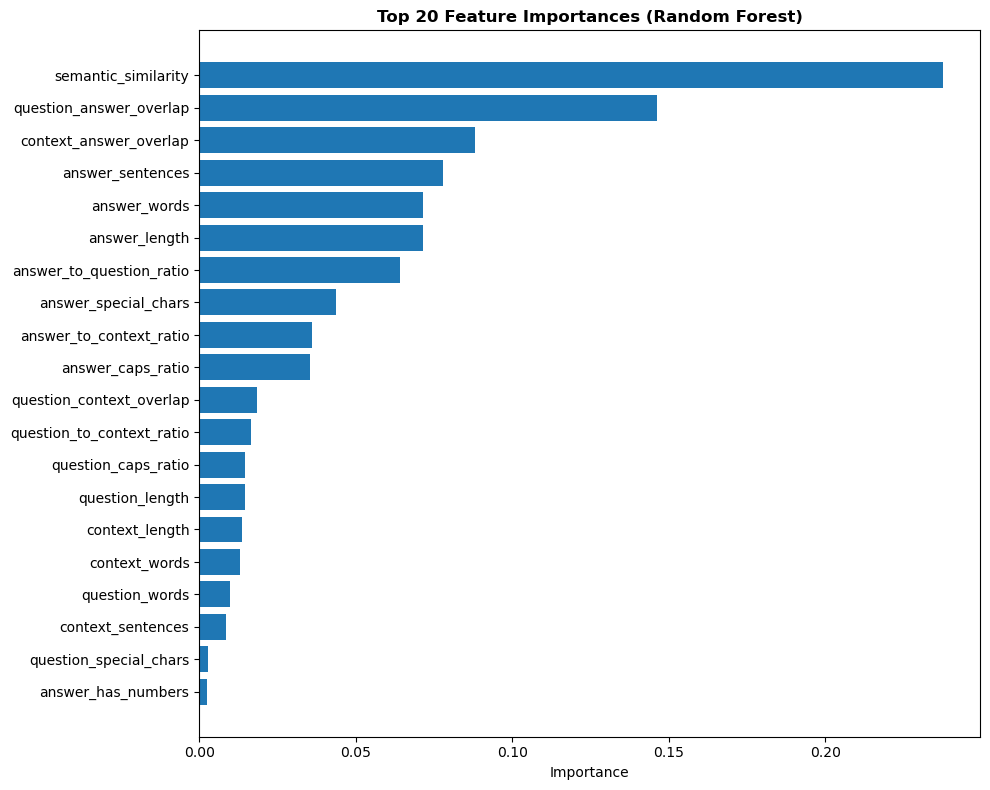

In [20]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Random Forest)', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 2 XG Boost Classifier

In [21]:
# XGBoost
print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_val_scaled)

print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_score(y_val, xgb_pred):.4f}")
print(f"F1 Score (macro): {f1_score(y_val, xgb_pred, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, xgb_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, xgb_pred, target_names=label_encoder.classes_))

Training XGBoost Classifier...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:06:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
Accuracy: 0.9646
F1 Score (macro): 0.9105
F1 Score (weighted): 0.9616

Classification Report:
               precision    recall  f1-score   support

contradiction       0.96      0.65      0.77       364
      factual       0.96      1.00      0.98      3487
   irrelevant       0.98      0.98      0.98       354

     accuracy                           0.96      4205
    macro avg       0.97      0.87      0.91      4205
 weighted avg       0.96      0.96      0.96      4205



### 3 Logistic Regression

In [22]:
# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    C=1.0
)

lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_val_scaled)
lr_pred_proba = lr_model.predict_proba(X_val_scaled)

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_val, lr_pred):.4f}")
print(f"F1 Score (macro): {f1_score(y_val, lr_pred, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, lr_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, lr_pred, target_names=label_encoder.classes_))

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.8830
F1 Score (macro): 0.7923
F1 Score (weighted): 0.8945

Classification Report:
               precision    recall  f1-score   support

contradiction       0.42      0.70      0.53       364
      factual       0.97      0.89      0.93      3487
   irrelevant       0.86      0.99      0.92       354

     accuracy                           0.88      4205
    macro avg       0.75      0.86      0.79      4205
 weighted avg       0.92      0.88      0.89      4205



### Ensemble Model Training

In [24]:
# Create ensemble using voting classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lr', lr_model)
    ],
    voting='soft',  # Use probabilities for voting
    weights=[2, 2, 1]  # Give more weight to RF and XGBoost
)

ensemble_model.fit(X_train_scaled, y_train)
ensemble_pred = ensemble_model.predict(X_val_scaled)
ensemble_pred_proba = ensemble_model.predict_proba(X_val_scaled)

print("Ensemble Model Results:")
print(f"Accuracy: {accuracy_score(y_val, ensemble_pred):.4f}")
print(f"F1 Score (macro): {f1_score(y_val, ensemble_pred, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, ensemble_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, ensemble_pred, target_names=label_encoder.classes_))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Model Results:
Accuracy: 0.9648
F1 Score (macro): 0.9103
F1 Score (weighted): 0.9618

Classification Report:
               precision    recall  f1-score   support

contradiction       0.97      0.64      0.77       364
      factual       0.96      1.00      0.98      3487
   irrelevant       0.97      0.98      0.98       354

     accuracy                           0.96      4205
    macro avg       0.97      0.87      0.91      4205
 weighted avg       0.97      0.96      0.96      4205



#### Re-Training and Test

In [25]:
# Retrain best model on full training data
print("Retraining best model on full training data...")

# Use ensemble as it typically performs best
final_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5,
                                      min_samples_leaf=2, random_state=42, n_jobs=-1, class_weight='balanced')),
        ('xgb', xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                                   subsample=0.8, colsample_bytree=0.8, random_state=42,
                                   eval_metric='mlogloss', use_label_encoder=False)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', C=1.0))
    ],
    voting='soft',
    weights=[2, 2, 1]
)

# Train on full dataset
X_full = scaler.fit_transform(X)
final_model.fit(X_full, y_encoded)

print("Final model trained successfully!")

Retraining best model on full training data...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:10:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final model trained successfully!


In [26]:
# Make predictions on test set
print("Making predictions on test set...")
test_predictions_encoded = final_model.predict(X_test_scaled)
test_predictions = label_encoder.inverse_transform(test_predictions_encoded)

# Add predictions to test dataframe
test_df['type'] = test_predictions

print(f"Predictions completed for {len(test_predictions)} test examples")
print("\nPrediction distribution:")
print(test_df['type'].value_counts())

Making predictions on test set...
Predictions completed for 2000 test examples

Prediction distribution:
type
factual          1770
irrelevant        195
contradiction      35
Name: count, dtype: int64


# Domain VI: Deployment

## Potential Integrations

A factuality classification model can be integrated directly into AI products in the Education Technology space, where users can get notified of which of their question/answer sets over a time period may have potential to be a contraditory or irrelevant statement. 

2 examples of these include:
1. Real-Time learning platforms
2. LMS (Learning Management System) ashboards, such as Canvas, for instructors to audit in the case they use AI generated content, before publishing to students.

For instance, users may receive an email weekly, showing them 5 times their question/answers fell were classified as non-facual, allowing them to label each as:
- Confirm
- Don't Confirm
- Am Unsure

These responses help see how they agree with the predictions. These labels can then be used for further model building to seek better imrpovements. 

## Productionalization Requirements 

1. **Code Modularization:** move repository from a notebook environment into scripts to allow for reproducability.
2. **Containerization:** via docker to ensure consistent behavior of model
3. **API management:** Companies may want to seek partnerships with LLM model companies to reduce cost of API calls, as they can be costly to absorb on their own.
4. **Cloud Hosting:** Hosting on (AWS/Azure/GCP) as high volumes will come with compute, storage and security concerns

Key parties to ensure success are Data Engineers, MLOps specialists, and Subject Matter Experts.

## Deployment Challenges

1. **Non-Determinism:** LLM models are non-deterministic and may label the same set of data differently. While temperature is set to 0, the solution can be customized to also provide a chain of thought in the response to make model's response more explainable to end users (At extra API cost as output tokens would increase)
2. **API Cost:** Propietary LLMs have superior ability to reason and therefore classify, but are expensive to run. Additional testing can be done to add additional prompt depth to less complex models (e.g GPT-5-nano as opposed to GPT-5.2) while minimizing drop in accuracy and F1 scores
3. **Out of Scope Inputs:** Model currently evaluates English text and does not handle multimodal content . Adding input guardrails to classify not supported messages as "Not Supported" can prevent them being misclassified. 
4. **Temporal Drift:** Knowledge can evolve over time and students may ask questions related to new topics. The LLM Judge must therefore continually update to models with later knowledge cutoff dates to prevent becoming obsolete. This may also require monitoring the few-shot prompt examples used in the model if they are no longer valid

## Testing, Re-Testing, and Validation

**A/B Testing**:
- In a real world implementation, a factuality detection feature can be rolled out and testing via A/B testing. For example, testing on a subset of the group, the number of errors reported between a control and treatment group can be compared. 

**Performance Testing**:
- The fact-checking process involves an API call, which can add time for an AI tutor or chatbot to respond to users. Tests can be put in place to ensure time is not added beyond a certrain threshold which may negatively impact the user experience. 


## Ethical Considerations

**Labeling Bias** - Model may inherit biases from the knowledge provided in few-shot example as well as knowledge LLM model is trained on. A human layer conssiting of a panel of diverse judges may need to be added to determine level of "agreement" on a model's labeling of a certain answer.

**Truth Bias** - Some fields are subjective, and the context of a prompt can be engineered for a model to believe certrain facts. Perhaps thinking of answers to questions as an "absolute truth" or "contradiction" may need to be re-evaluated, and labels such as "supported by model knowledge", or "supported by provided context" may represent this nuance better.

**Data Privacy** - Data anonymization is an important element of using student data, even when using APIs that do not use user input data for model training (such as the OpenAI API). A script may need to be developed to mask any recognizable entities within the provided text such as names, locations, IDs, before the data is sent to the API.



---



# Domain VII: Analytics Solution Lifecycle Management

## Post-Deployment Maintainence and Improvement Plan

1. **Performance Tracking - Detecting Data Drift:** Questions can become more complex overtime as LLMs become more capable. "Contexts" can also become larger and more technical as models can retain more tokens. Using the EDA in place, the model can detect changes in the distribution of lengths of questions and contexts, setting the groundwork for investigating impact.

2. **Performance Tracking - Business Validation:** Expected behavior is that a majority of cases are factual. A "brakes system" will be implemented if this rule is every violated, as it may signal errors causing misclassification. For instance, if contradiction and irrelevant rates spike abnormally to 20% of all answers, developers will be ifnormed to investigate this surge. 

## Potential Future Changes in Deployment Environment

- **Cost Reduction**: As open-weight models become more capable the environment may be able to shift to self-hosted open weight models to reduce API cost

## Evolution of Problem Statement

- **Adding Explainability**: Additional phases may want to add explainability to be able to interpret classifications. This is helpful if for example, an individual wants to learn from an error. While this can be added within the model, it should be noted the addition of output tokens increases overall cost. 

- **Adding Multilingual Scope:** As digital education expands globally, the problem statement will shift from detecting factuality in English-only contexts to supporting a multilingual student base. It may even evolve to cross-lingual use cases, for instance where users need to know if a certrain translation is correct or incorrect. This is important to address for overall Equity in Education, as it democratizes access to knowledge validation. 

- **Adding Multimodal Scope:** The original problem focuses strictly on text-based question-and-answer sets. With both LLM inputs and outputs becoming increasingly multimodal, the problem statement will need to evolve to become capable of verifying the outputs between different cross-modes of inputs and outputs. 


---


# Appendix

## 0. Majority Classifier - Baseline Model
This simple model establishes baseline performance to improve upon in subsequent higher complexity approaches. It finds the majority class, and uses it to predict all rows. Since theres a class bias towards factual, we are expecting high accuracy but low macro F1

### Using Stratified K-Fold

In the model developments to come, stratified K-Fold cross validation (stratified to address the class imbalance issue) will be used to reduce bias from a single split of the dataset. 5 splits will be done, and any confusion matrices and metric reports will be done using the cross-validation results.

Sample Implementation of Stratified K-Fold CV approach for the majority classifier

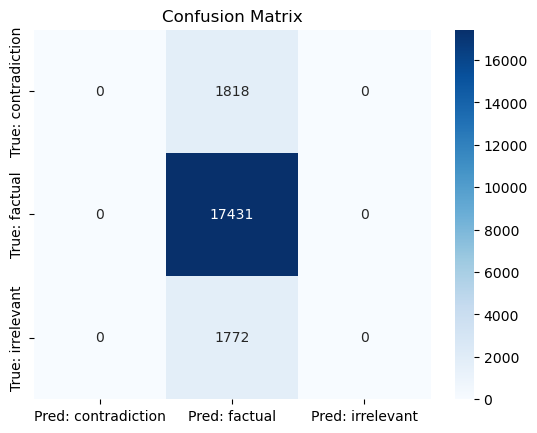

               precision    recall  f1-score   support

contradiction       0.00      0.00      0.00      1818
      factual       0.83      1.00      0.91     17431
   irrelevant       0.00      0.00      0.00      1772

     accuracy                           0.83     21021
    macro avg       0.28      0.33      0.30     21021
 weighted avg       0.69      0.83      0.75     21021



In [ ]:
# Use Stratified K-Fold to Address Class-Imbalances. 
# This kf will be reused throughout the notebook. No need to redefine, this will ensure all models use the same splits.
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For confusion matrix (aggregate)
all_true = []
all_pred = []

classes = sorted(train_df['type'].unique())  # alphabetical order

for train_index, val_index in kf.split(train_df, train_df["type"]):

    train_fold = train_df.iloc[train_index]
    val_fold   = train_df.iloc[val_index].copy()   # <–– prevent assignment warning

    # Majority class baseline for this fold
    maj = train_fold['type'].value_counts().idxmax()
    val_fold['pred'] = maj

    # Store for aggregate confusion matrix
    all_true.extend(val_fold['type'].tolist())
    all_pred.extend(val_fold['pred'].tolist())

evaluate_model(all_true, all_pred, classes)

## 1. Classical Machine Learning Models
These models use engineered features to learn decision boundaries to perform classification with.

**Choosing a Vectorizer: CountVectorizer vs TF-IDF**

*Vectorization: process of converting raw data, such as text, into a numerical format (vectors) that machine learning algorithms can process*

*CountVectorizer (Bag of Words): Count Word Frequency*

*TF-IDF (Term Frequency Inverse Document Frequency) Count Word Frequency in relation to its frequency across the entire dataset*

**Decision:** TF-IDF (Still weak, but captures meaning better than raw counts and does not give importance to stop words)

### 1.1.0 TFIDF Logistic Regression with Default Settings

We are attempting to capture relationship between any type of words appearing or being absent and whether that answer is (F,C,I). While term-frequency does not take context and relationship between entities into account and cannot capture truth, we want to see if there is any predictive capability in looking at these relationships.

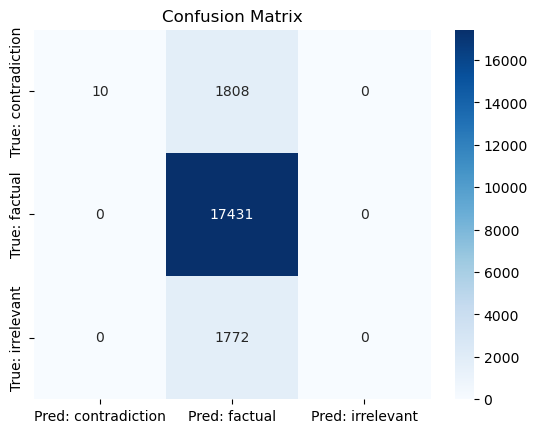

               precision    recall  f1-score   support

contradiction       1.00      0.01      0.01      1818
      factual       0.83      1.00      0.91     17431
   irrelevant       0.00      0.00      0.00      1772

     accuracy                           0.83     21021
    macro avg       0.61      0.34      0.31     21021
 weighted avg       0.77      0.83      0.75     21021



In [ ]:
# For confusion matrix
all_true = []
all_pred = []

classes = sorted(train_df['type'].unique())  # alphabetical order

for train_index, val_index in kf.split(train_df, train_df["type"]): # kf splits train_df into train and val indices

    train_fold = train_df.iloc[train_index] 
    val_fold   = train_df.iloc[val_index].copy()

    # ---- Combine fields ----
    train_combined = (
        train_fold["question"] + " " +
        train_fold["answer"]   + " " +
        train_fold["context"]
    )

    val_combined = (
        val_fold["question"] + " " +
        val_fold["answer"]   + " " +
        val_fold["context"]
    )

    # ---- TF-IDF for THIS fold ----
    vectorizer = TfidfVectorizer() # Refit in each fold preventing data leakage
    X_train = vectorizer.fit_transform(train_combined)
    X_val   = vectorizer.transform(val_combined)

    # ---- Logistic Regression ----
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, train_fold["type"])

    # ---- Predictions ----
    preds = clf.predict(X_val)

    # Collect for aggregate confusion matrix
    all_true.extend(val_fold["type"].tolist())
    all_pred.extend(preds.tolist())
    
evaluate_model(all_true, all_pred, classes)

### 1.1.1 TFIDF Logistic Regression with Balanced Class Weighting

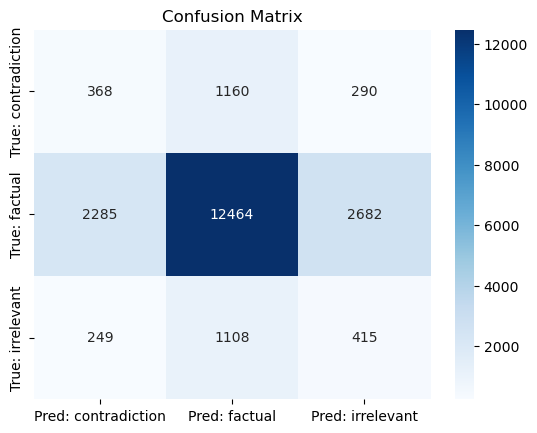

               precision    recall  f1-score   support

contradiction       0.13      0.20      0.16      1818
      factual       0.85      0.72      0.78     17431
   irrelevant       0.12      0.23      0.16      1772

     accuracy                           0.63     21021
    macro avg       0.37      0.38      0.36     21021
 weighted avg       0.72      0.63      0.67     21021



In [159]:
# For confusion matrix
all_true = []
all_pred = []

classes = sorted(train_df['type'].unique())  # alphabetical order

for train_index, val_index in kf.split(train_df, train_df["type"]):

    train_fold = train_df.iloc[train_index]
    val_fold   = train_df.iloc[val_index].copy()

    # ---- Combine fields ----
    train_combined = (
        train_fold["question"] + " " +
        train_fold["answer"]   + " " +
        train_fold["context"]
    )

    val_combined = (
        val_fold["question"] + " " +
        val_fold["answer"]   + " " +
        val_fold["context"]
    )

    # ---- TF-IDF for THIS fold ----
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_combined)
    X_val   = vectorizer.transform(val_combined)

    # ---- Logistic Regression ----
    clf = LogisticRegression(class_weight='balanced' , max_iter=5000)
    clf.fit(X_train, train_fold["type"])

    # ---- Predictions ----
    preds = clf.predict(X_val)

    # Collect for aggregate confusion matrix
    all_true.extend(val_fold["type"].tolist())
    all_pred.extend(preds.tolist())

evaluate_model(all_true, all_pred, classes)


### 1.1.2 TFIDF Logistic Regression with Balanced Class Weighting +  n-grams



==== Logistic Regression (TF-IDF) — 5-Fold Cross Validation ====

   Accuracy  Precision Macro  Recall Macro  F1 Macro
0    0.7133           0.3604         0.357    0.3572

Per-Class Averages Across Folds:
               Precision  Recall  F1 Score
contradiction     0.1432  0.1056    0.1216
factual           0.8352  0.8360    0.8356
irrelevant        0.1027  0.1292    0.1145

=== Aggregate Confusion Matrix (5-Fold Combined) ===


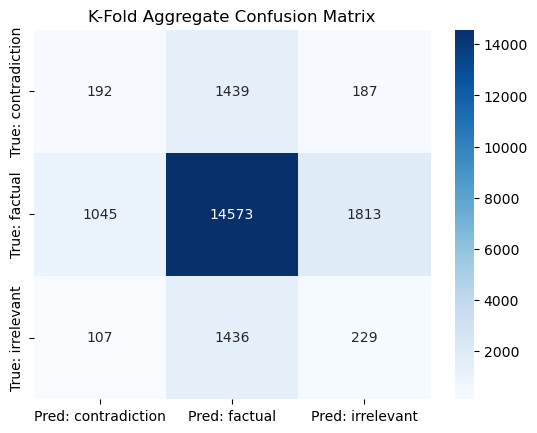

In [ ]:
# For confusion matrix
all_true = []
all_pred = []

classes = sorted(train_df['type'].unique())  # alphabetical order

for train_index, val_index in kf.split(train_df, train_df["type"]):

    train_fold = train_df.iloc[train_index]
    val_fold   = train_df.iloc[val_index].copy()

    # ---- Combine fields ----
    train_combined = (
        train_fold["question"] + " " +
        train_fold["answer"]   + " " +
        train_fold["context"]
    )

    val_combined = (
        val_fold["question"] + " " +
        val_fold["answer"]   + " " +
        val_fold["context"]
    )

    # ---- TF-IDF for THIS fold ----
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    X_train = vectorizer.fit_transform(train_combined)
    X_val   = vectorizer.transform(val_combined)

    # ---- Logistic Regression ----
    clf = LogisticRegression(class_weight='balanced' , max_iter=5000)
    clf.fit(X_train, train_fold["type"])

    # ---- Predictions ----
    preds = clf.predict(X_val)

    # Collect for aggregate confusion matrix
    all_true.extend(val_fold["type"].tolist())
    all_pred.extend(preds.tolist())

evaluate_model(all_true, all_pred, classes)
